In [1]:
from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river import forest
from river import stream
from river import ensemble
from river import tree
from river.drift import ADWIN, KSWIN, PageHinkley

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

In [3]:
PROJECT_ROOT                     = "../"

SOURCE_DATASET_ROOT              = PROJECT_ROOT + "datasets/isp3/"

SOURCE_DATASET_FILENAME          = SOURCE_DATASET_ROOT + "[dvwa.isp_xvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_D        = SOURCE_DATASET_ROOT + "[dvwa.isp]_https_apache.csv"
SOURCE_DATASET_FILENAME_X        = SOURCE_DATASET_ROOT + "[xvwa.isp]_https_apache.csv"
# SOURCE_DATASET_TRAIN_FILENAME    = SOURCE_DATASET_ROOT + "DataSetN_Train.csv"
# SOURCE_DATASET_TEST_FILENAME     = SOURCE_DATASET_ROOT + "DataSetN_Test.csv"

# Фичи

In [4]:
df = pd.read_csv(SOURCE_DATASET_FILENAME)
df['Label'].value_counts()

/tmp/ipykernel_892430/3322869287.py:1: DtypeWarning: Columns (3,103,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SOURCE_DATASET_FILENAME)


Label
Web Attack - DDoS                 65295
Benign                             4446
Web Attack - XSS                   2686
Web Attack - SQL Injection         1483
Web Attack - Command Injection     1400
Web Attack - Brute Force            497
Web Attack - Web Shell              353
Web Attack - CSRF                    60
Name: count, dtype: int64

In [5]:
excluded = ['Flow_ID', 'Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol', 'Timestamp', "Unnamed: 0", "xvwa.isp", "Label", "dvwa.isp"]
df = df.drop(columns=excluded, errors='ignore')

In [6]:
excluded2 = ['Session_Index',  'Target','Http_Reqest','Root','GlobalLabel','Type','Tools','ToolsThreads','ToolsDelay','ToolsAdditional',
             'ChannelSpeedBefore','ChannelSpeedAfter','NetemString','Server','KeepAliveTimeout','TargetProtocol','File','SessionAnalizerMode']
df = df.drop(columns=excluded2, errors='ignore')

In [7]:
# webattack_features = ['Flow_Duration',
#  'Total_Fwd_Packets',
#  'Fwd_Packet_Length_Max',
#  'Bwd_Packet_Length_Max',
#  'Flow_Bytes_s',
#  'Flow_Packets_s',
#  'Flow_IAT_Min',
#  'Fwd_IAT_Min',
#  'Bwd_IAT_Mean',
#  'Bwd_IAT_Std',
#  'Bwd_IAT_Min',
#  'Packet_Length_Variance',
#  'Fwd_FIN_Flags',
#  'Fwd_SYN_Flags',
#  'Fwd_RST_Flags',
#  'Bwd_FIN_Flags',
#  'Stream_Session_Number',
#  'Stream_Was_Prev_Session',
#  'Stream_Was_Next_Session',
#  'Stream_Sessions_On_Start',
#  'Stream_Sessions_On_Close',
#  'Stream_Session_Intervals_Min_Duration',
#  'Stream_Session_Intervals_Std_Duration',
#  'Stream_Session_Durations_Min_Duration',
#  'Stream_Session_Durations_Max_Duration',
#  'Fwd_Bandwidth_Max',
#  'Bwd_Bandwidth_Min',
#  'Bwd_Bandwidth_Max']
webattack_features = ['Flow_Duration',
 'Total_Fwd_Packets',
 'Fwd_Packet_Length_Max',
 'Bwd_Packet_Length_Max',
 'Flow_Bytes_s',
 'Flow_Packets_s',
 'Flow_IAT_Min',
 'Fwd_IAT_Min',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Min',
 'Packet_Length_Variance',
 'Fwd_FIN_Flags',
 'Fwd_SYN_Flags',
 'Fwd_RST_Flags',
 'Bwd_FIN_Flags',
 'Stream_Session_Number',
 'Stream_Was_Prev_Session',
 'Stream_Was_Next_Session',
 'Stream_Session_Intervals_Min_Duration',
 'Stream_Session_Intervals_Std_Duration',
 'Stream_Session_Durations_Min_Duration',
 'Stream_Session_Durations_Max_Duration',
 'Fwd_Bandwidth_Max',
 'Bwd_Bandwidth_Min',
 'Bwd_Bandwidth_Max']

In [8]:
# webattack_features = list(df.columns)
# webattack_features

# Выбор гиперпараметров

In [9]:
best_params_ = {
    'max_depth': 17,
    'max_features': 10,
    # 'min_samples_leaf': 3,
    'n_models': 50
}

# Подготовка датасета

In [10]:
def prepare_dataset(name, train_size=0.2, test_size=0.8):
    df = pd.read_csv(name)
    df['Label'].value_counts()

    label_rows = df[df['Label'] == 'Web Attack - DDoS']
    rows_to_remove = label_rows.sample(frac=0.94, random_state=42)
    df = df.drop(index=rows_to_remove.index)
    df['Label'].value_counts()
    
    attacks = {
        'Web Attack - XSS',
        'Web Attack - CSRF',
        'Web Attack - Brute Force',
        'Web Attack - Web Shell',
        'Web Attack - Command Injection',
        'Web Attack - SQL Injection',
        'Web Attack - DDoS'
    }
    attack_to_exclude = {}
    benign = {'Benign', 'FromInSide'}

    df['Label'] = df['Label'].replace(to_replace=benign, value='Benign')
    df['Label'].value_counts()

    df_full = df[df['Label'].isin(attacks | benign)].copy()
    df_full['Label'].value_counts()
    
    # df_full = df_full.groupby('Label').apply(lambda x: x.sample(n=6000, replace=True)).reset_index(drop=True)

    X = df_full[webattack_features]
    y = df_full['Label']
    if train_size == 0 and test_size == 1:
        return [], X, [], y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, 
                                                            train_size=train_size, test_size=test_size, shuffle=True, random_state=0)
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test1, y_train, y_test1 = prepare_dataset(SOURCE_DATASET_FILENAME_D, train_size=0.6, test_size=0.4)
_, X_test2, _, y_test2 = prepare_dataset(SOURCE_DATASET_FILENAME_X, train_size=0.6, test_size=0.4)
X_test = pd.concat([X_test1, X_test2])
y_test = pd.concat([y_test1, y_test2])

/tmp/ipykernel_892430/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)
/tmp/ipykernel_892430/1871289745.py:2: DtypeWarning: Columns (103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name)


In [12]:
point = len(y_test1)
print(y_train.shape)
print(y_test1.shape)
print(y_test2.shape)
print(y_test.shape)

(4056,)
(2704,)
(3233,)
(5937,)


# Обучение

In [13]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name, dr=[]):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg F1-score: %.2f%%'%(m[-1]))
    m_min = np.array(m).min()

    for i in range(len(dr)):
        if i!=0:
            # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
            plt.vlines(dr[i], m_min, 100, colors = "red", linewidth=2, linestyles = "dashed")
    
    plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
    plt.legend(loc='best')
    plt.title(name+' on [dvwa.isp_xvwa.isp]_https_apache', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('F1 (%)')
    plt.ylim(0, 102)

    plt.draw()

In [14]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test, l=True):
    metric = metrics.MicroF1() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
        model.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in tqdm(stream.iter_pandas(X_test, y_test), total=y_test.shape[0]):
        y_pred= model.predict_one(xi)  # Predict the test sample
        if l:
            model.learn_one(xi,yi) # Learn the test sample
        metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
    return t, m

In [15]:
class PWPAE:
    def __init__(self):
        self.ws = [0,0,0,0]
        self.ep = 0.001
        
        self.hat1 = forest.ARFClassifier(n_models = 3, drift_detector = KSWIN()) # ARF-KSWIN
        self.hat2 = forest.ARFClassifier(n_models = 3, drift_detector = PageHinkley()) # ARF-PageHinkley
        self.hat3 = ensemble.SRPClassifier(n_models=3) # ARF
        self.hat4 = ensemble.SRPClassifier(n_models = 3, drift_detector = KSWIN()) # SRP-KSWIN
    
    def fit(self, X_train, y_train):
        for xi1, yi1 in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            self.hat1.learn_one(xi1,yi1)
            self.hat2.learn_one(xi1,yi1)
            self.hat3.learn_one(xi1,yi1)
            self.hat4.learn_one(xi1,yi1)
    
    def partial_fit(self, X_train, y_train):
        metric = metrics.MacroF1()
        metric1 = metrics.MacroF1()
        metric2 = metrics.MacroF1()
        metric3 = metrics.MacroF1()
        metric4 = metrics.MacroF1()
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        y_probs = []
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            # The four base learner predict the labels
            y_pred1= self.hat1.predict_one(xi) 
            y_prob1= self.hat1.predict_proba_one(xi) 

            y_pred2= self.hat2.predict_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)

            y_pred3= self.hat3.predict_one(xi) 
            y_prob3= self.hat3.predict_proba_one(xi)

            y_pred4= self.hat4.predict_one(xi) 
            y_prob4= self.hat4.predict_proba_one(xi)

            
            # Record their real-time accuracy
            metric1.update(yi, y_pred1)
            metric2.update(yi, y_pred2)
            metric3.update(yi, y_pred3)
            metric4.update(yi, y_pred4)    

            # Calculate the real-time error rates of four base learners
            e1 = 1-metric1.get()
            e2 = 1-metric2.get()
            e3 = 1-metric3.get()
            e4 = 1-metric4.get()
            
            # Calculate the weight of each base learner by the reciprocal of its real-time error rate
            ea = 1/(e1+self.ep)+1/(e2+self.ep)+1/(e3+self.ep)+1/(e4+self.ep)
            self.ws[0] = 1/(e1+self.ep)/ea
            self.ws[1] = 1/(e2+self.ep)/ea
            self.ws[2] = 1/(e3+self.ep)/ea
            self.ws[3] = 1/(e4+self.ep)/ea

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            self.hat1.learn_one(xi,yi)
            self.hat2.learn_one(xi,yi)
            self.hat3.learn_one(xi,yi)
            self.hat4.learn_one(xi,yi)

            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)
            
            # Update the real-time accuracy of the ensemble model
            metric.update(yi, y_pred_all)

            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            y_probs.append(y_prob_all.max())
            
            i=i+1
            
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m, dr, y_probs
    
    def predict_test(self, X_train, y_train):
        metric = metrics.MacroF1()
        metric1 = metrics.MacroF1()
        metric2 = metrics.MacroF1()
        metric3 = metrics.MacroF1()
        metric4 = metrics.MacroF1()
        
        i=0
        t = []
        m = []
        yt = []
        yp = []
        dr = []
        dr_c = 0
        y_probs = []
        
        for xi, yi in tqdm(stream.iter_pandas(X_train, y_train), total=y_train.shape[0]):
            y_prob1= self.hat1.predict_proba_one(xi) 
            y_prob2= self.hat2.predict_proba_one(xi)
            y_prob3= self.hat3.predict_proba_one(xi)
            y_prob4= self.hat4.predict_proba_one(xi)

            # Make ensemble predictions by the classification probabilities
            y_prob_all = (self.ws[0]*pd.Series(y_prob1) + self.ws[1]*pd.Series(y_prob2) + self.ws[2]*pd.Series(y_prob3) + self.ws[3]*pd.Series(y_prob4))/4
            y_pred_all = y_prob_all.idxmax()
            
            if dr_c < self.hat1.n_drifts_detected():
                dr_c = self.hat1.n_drifts_detected()
                dr.append(i)

            # Update the real-time accuracy of the ensemble model
            metric.update(yi, y_pred_all)

            t.append(i)
            m.append(metric.get()*100)
            yt.append(yi)
            yp.append(y_pred_all)
            y_probs.append(y_prob_all.max())
            
            i=i+1
        print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
        print("Precision: "+str(round(precision_score(yt,yp, average='weighted'),4)*100)+"%")
        print("Recall: "+str(round(recall_score(yt,yp, average='weighted'),4)*100)+"%")
        print("F1-score: "+str(round(f1_score(yt,yp, average='weighted'),4)*100)+"%")
        return t, m, dr, y_probs

In [16]:
pwpae = PWPAE()

  0%|          | 0/4056 [00:00<?, ?it/s]

  0%|          | 0/4056 [00:00<?, ?it/s]

Accuracy: 96.35000000000001%
Precision: 96.15%
Recall: 96.35000000000001%
F1-score: 96.12%


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/5937 [00:00<?, ?it/s]

Accuracy: 94.04%
Precision: 93.97%
Recall: 94.04%
F1-score: 93.69%
CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 2min 14s


/home/jupyter-yutony/.conda/envs/attack-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


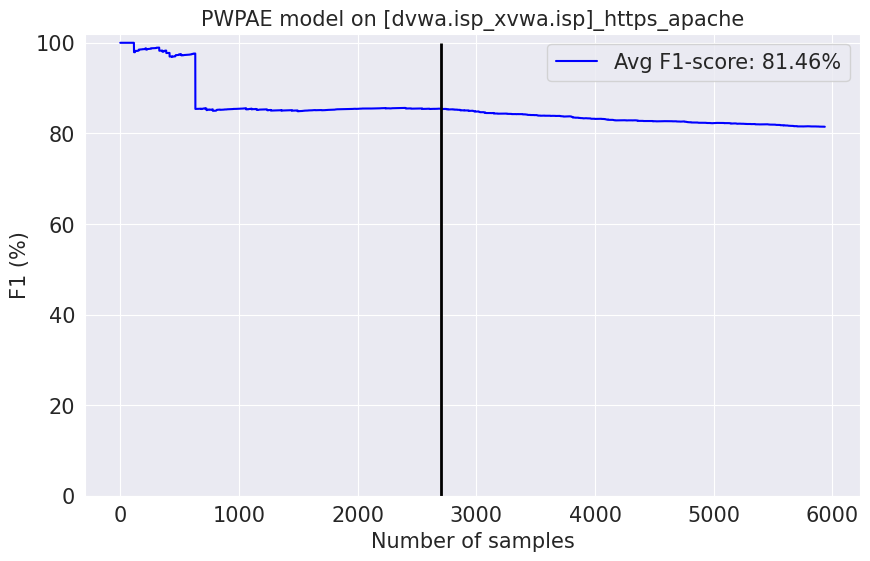

In [17]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name = "PWPAE model"
pwpae.fit(X_train, y_train)
t, m, dr, y_probs_old = pwpae.partial_fit(X_train, y_train)
t, m, dr, y_probs = pwpae.predict_test(X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name, dr) # Draw the figure of how the real-time accuracy changes with the number of samples

In [18]:
y_probs_old = np.array(y_probs_old)
y_probs = np.array(y_probs)

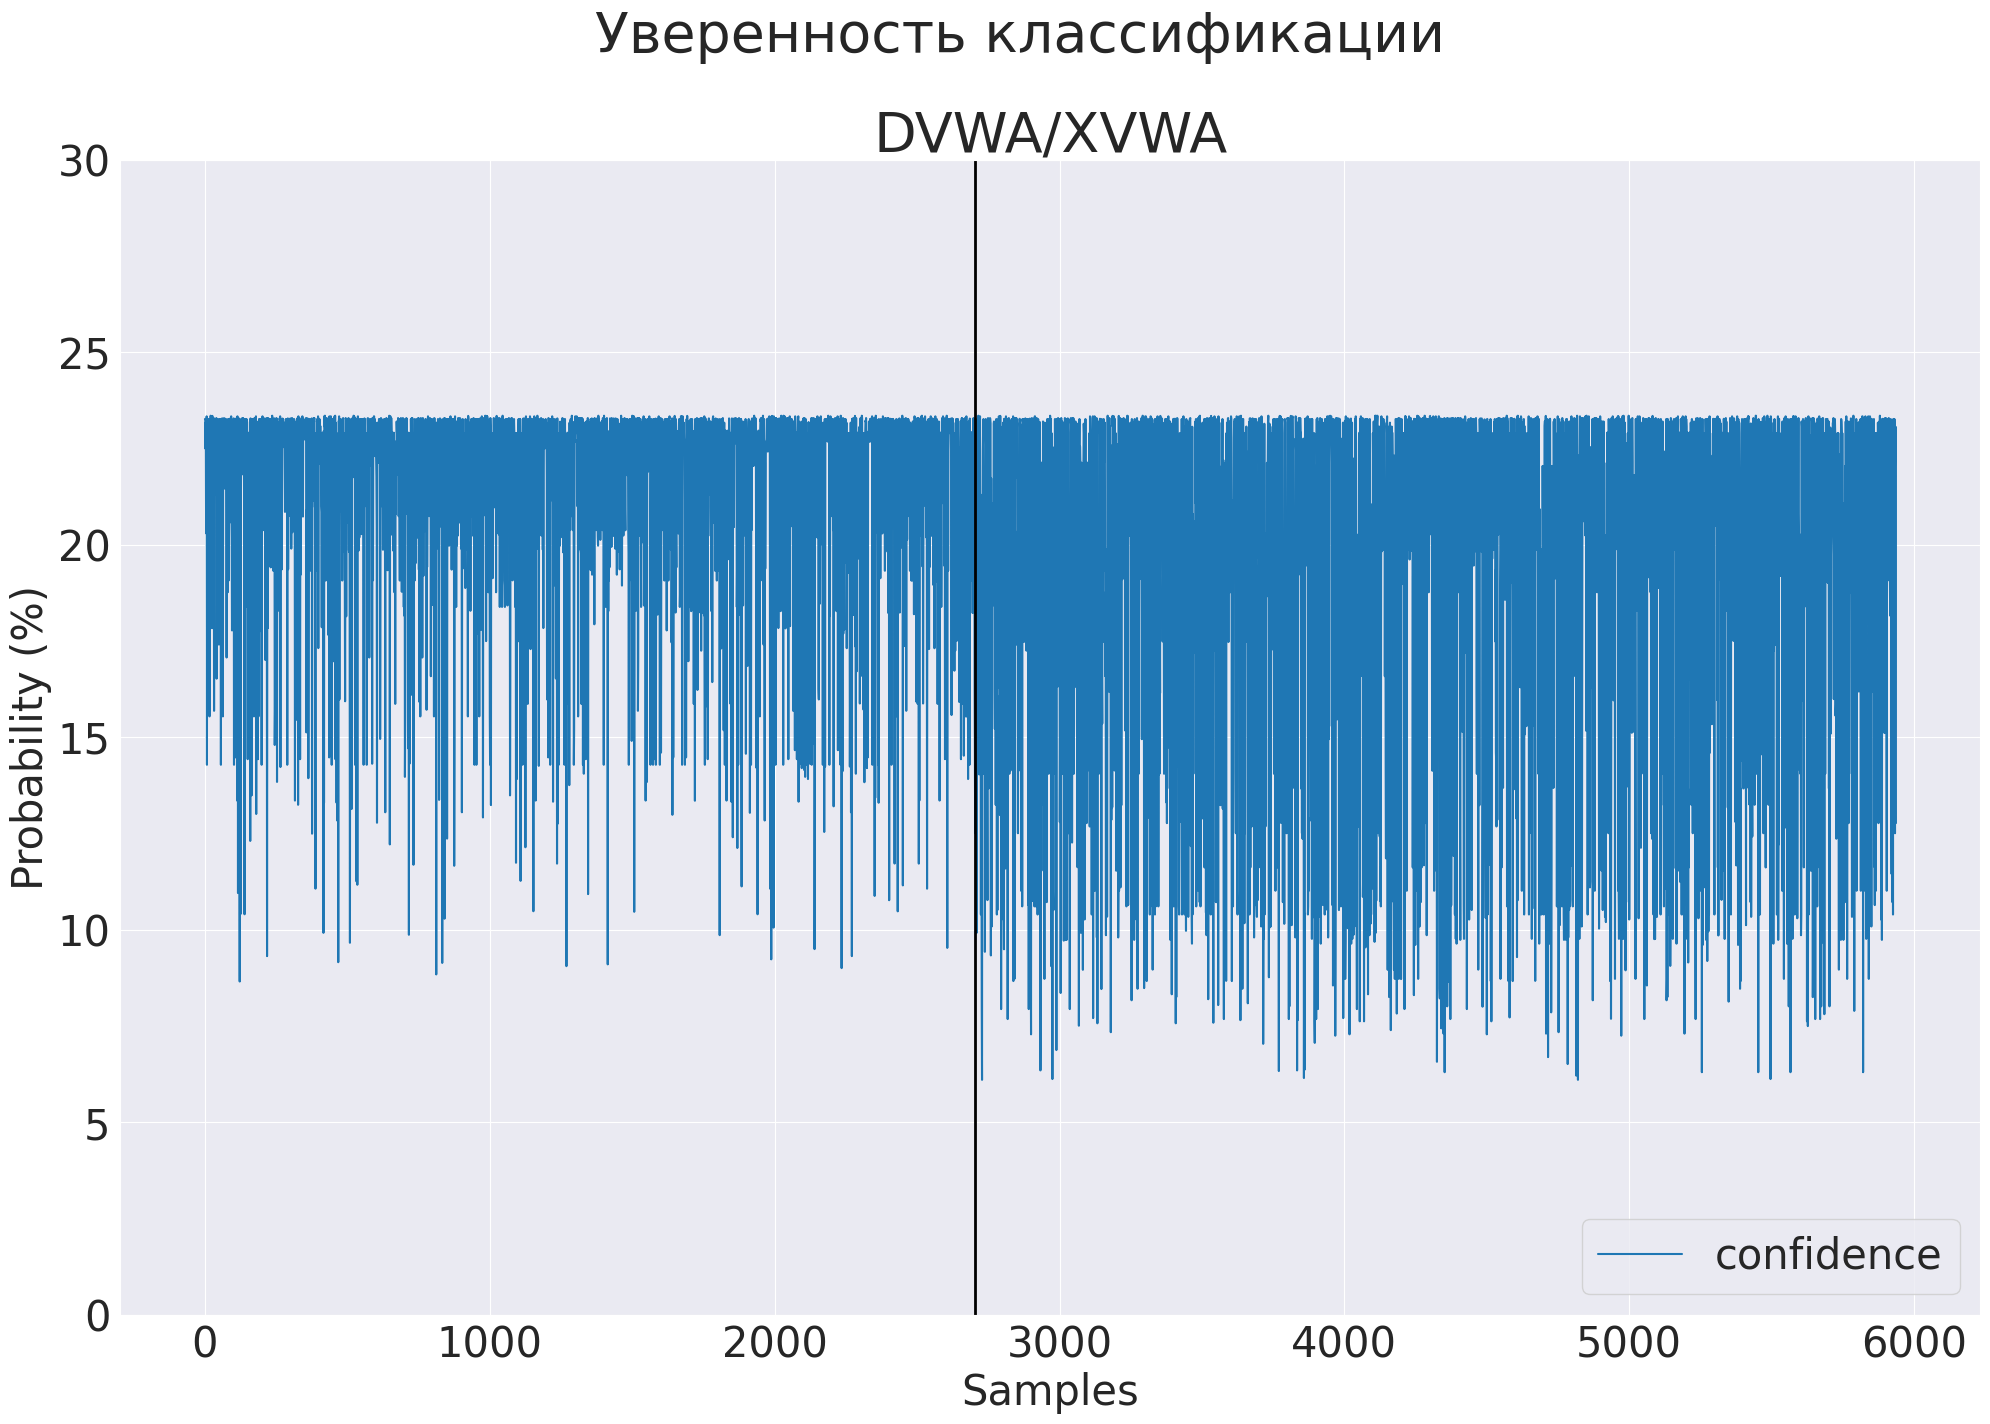

In [19]:
# Draw a comprehensive figure to compare the performance of all models
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

plt.plot(t,y_probs*100,label='confidence')
# Draw the drift points/time
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, 0, 100, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(0, 30)
plt.title('DVWA/XVWA', fontsize=40)
plt.suptitle("Уверенность классификации", fontsize=40)
plt.xlabel('Samples')
plt.ylabel('Probability (%)')
plt.savefig("probability.png")

In [20]:
print(y_probs_old.shape)
print(y_probs.shape)

(4056,)
(5937,)


In [21]:
from river import stats

auto_corr = stats.AutoCorr(lag=50)
# auto_corr = stats.Entropy(fading_factor=1)
corr = []
for x in y_probs:
    auto_corr.update(x)
    corr.append(auto_corr.get())

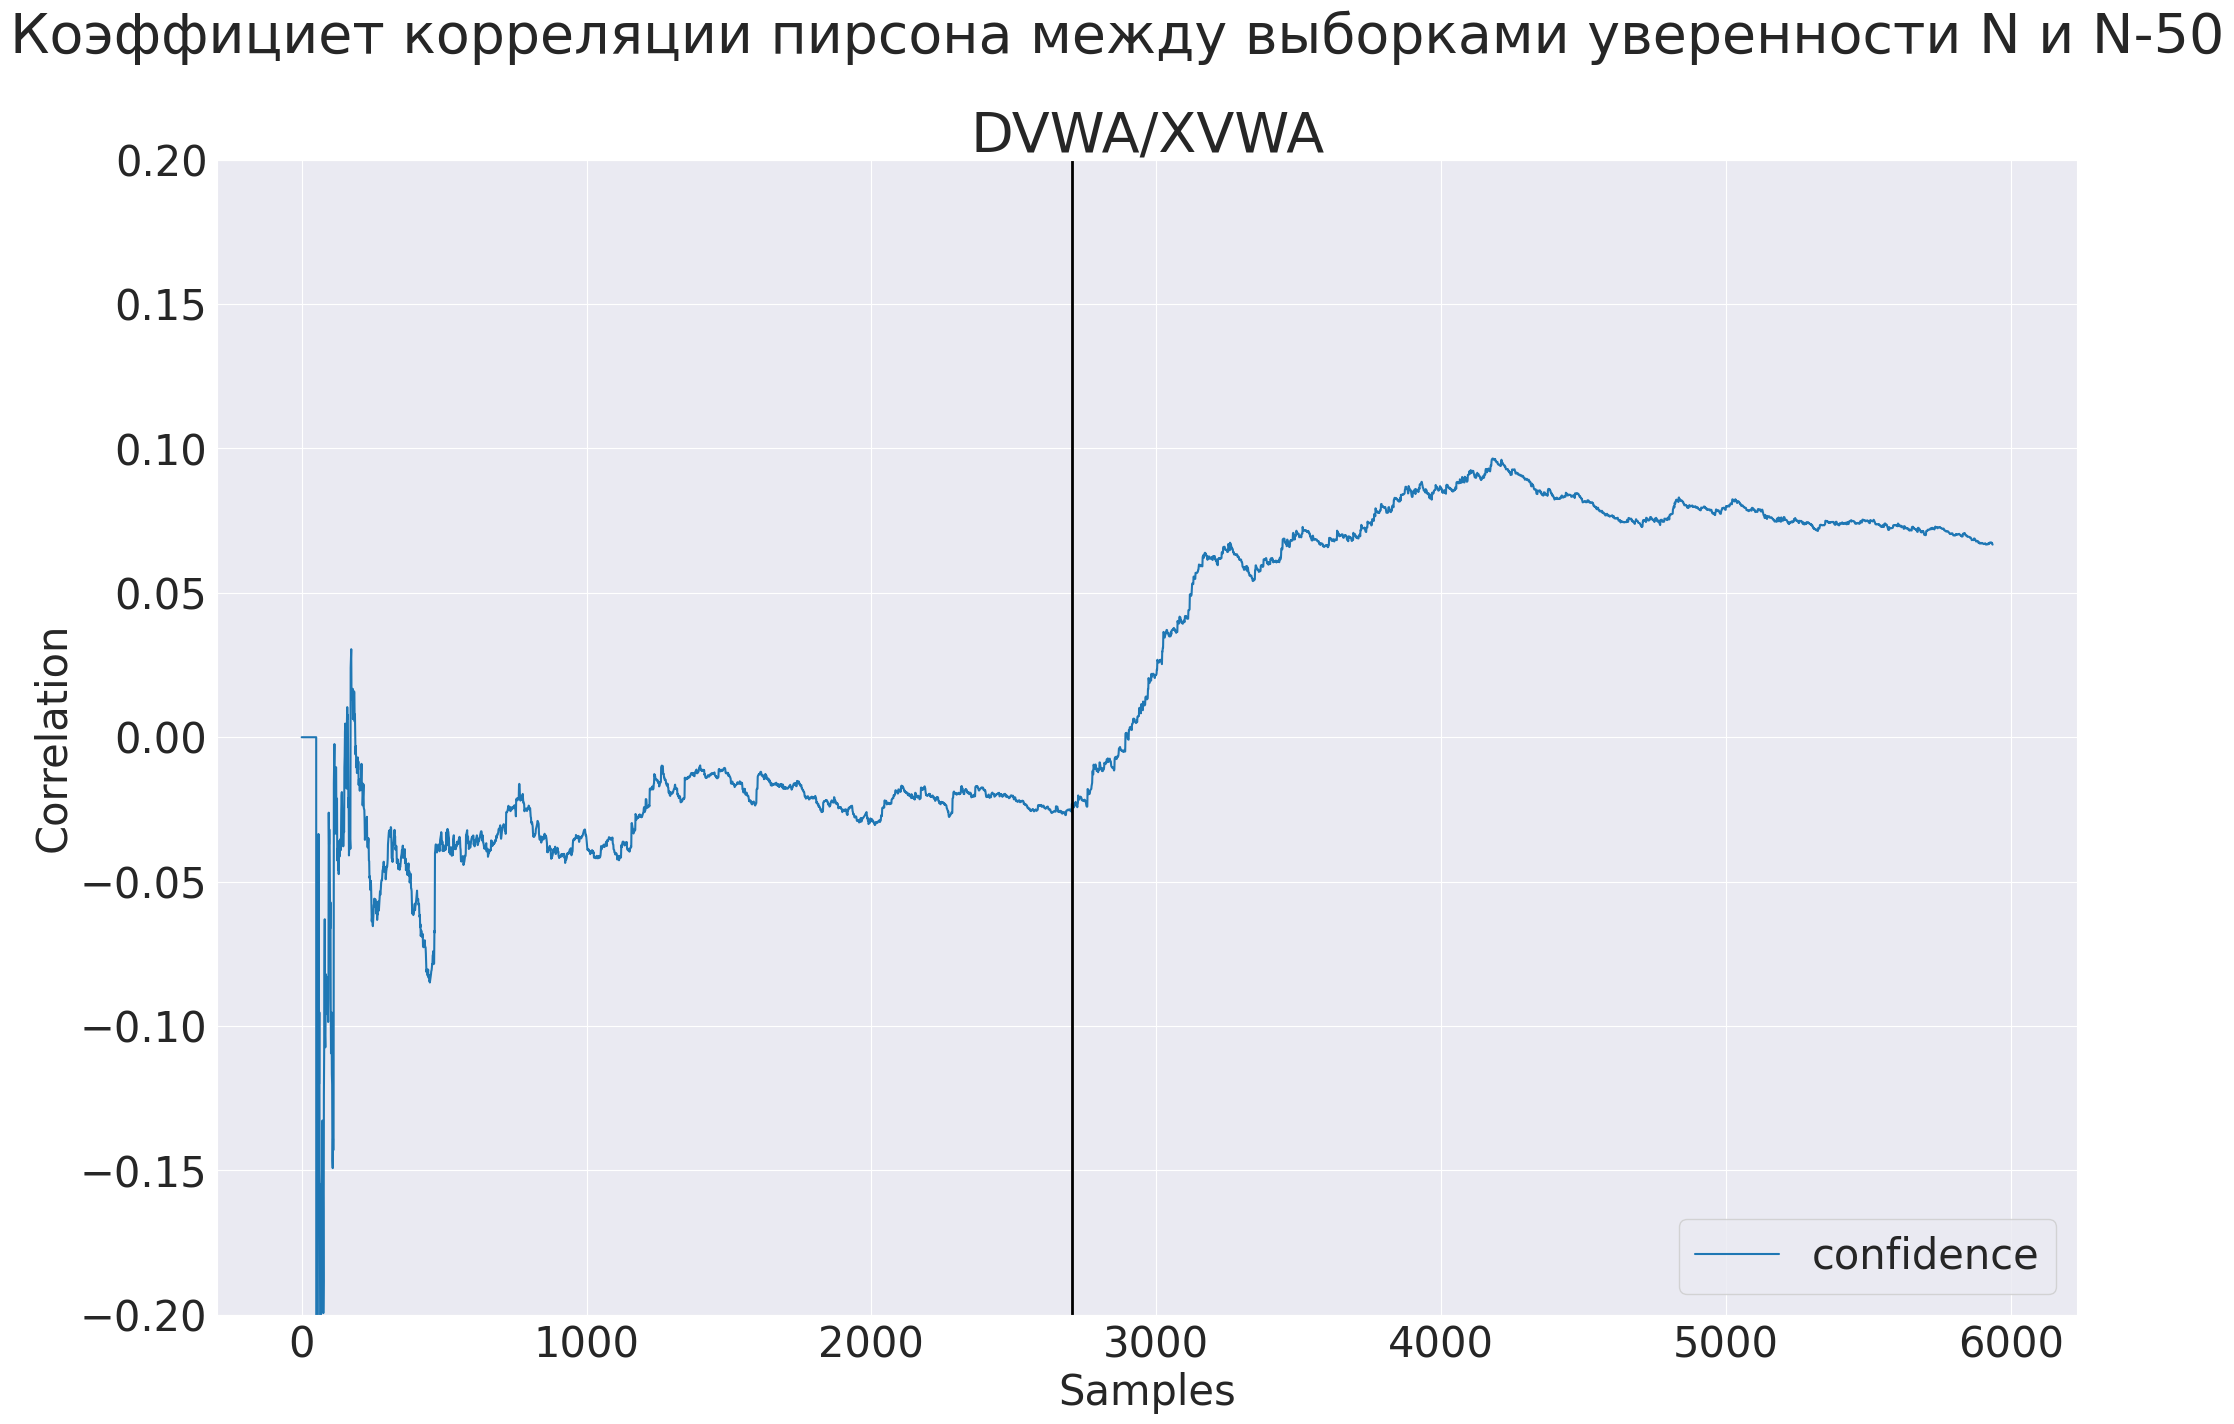

In [22]:
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

plt.plot(t,corr,label='confidence')
# Draw the drift points/time
for i in range(len(dr)):
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=2, linestyles = "dashed")

plt.vlines(point, -1, 1, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(-0.2, 0.2)
plt.title('DVWA/XVWA', fontsize=40)
plt.suptitle("Коэффициет корреляции пирсона между выборками уверенности N и N-50", fontsize=40)
plt.xlabel('Samples')
plt.ylabel('Correlation')
plt.savefig("correlation.png")

In [23]:
drift = ADWIN()
dr_adwin = []
est = []
for i in range(y_probs.shape[0]):
    drift.update(y_probs[i])
    if drift.drift_detected:
        print(f"Change detected at index {i}, input value: {y_probs[i]}")
        dr_adwin.append(i)
    est.append(drift.estimation)

Change detected at index 3519, input value: 0.23265032321230872


In [24]:
drift = KSWIN(alpha=0.0005, window_size=100, stat_size=30)
dr_KSWIN = []
for i in range(y_probs.shape[0]):
    drift.update(y_probs[i])
    if drift.drift_detected:
        print(f"Change detected at index {i}, input value: {y_probs[i]}")
        dr_KSWIN.append(i)

In [25]:
drift = PageHinkley(min_instances=30, delta=0.0005, threshold=20.0, alpha=0.9999)
dr_pk = []
for i in range(y_probs.shape[0]):
    drift.update(y_probs[i])
    if drift.drift_detected:
        print(f"Change detected at index {i}, input value: {y_probs[i]}")
        dr_pk.append(i)

Change detected at index 3717, input value: 0.09762488886792317


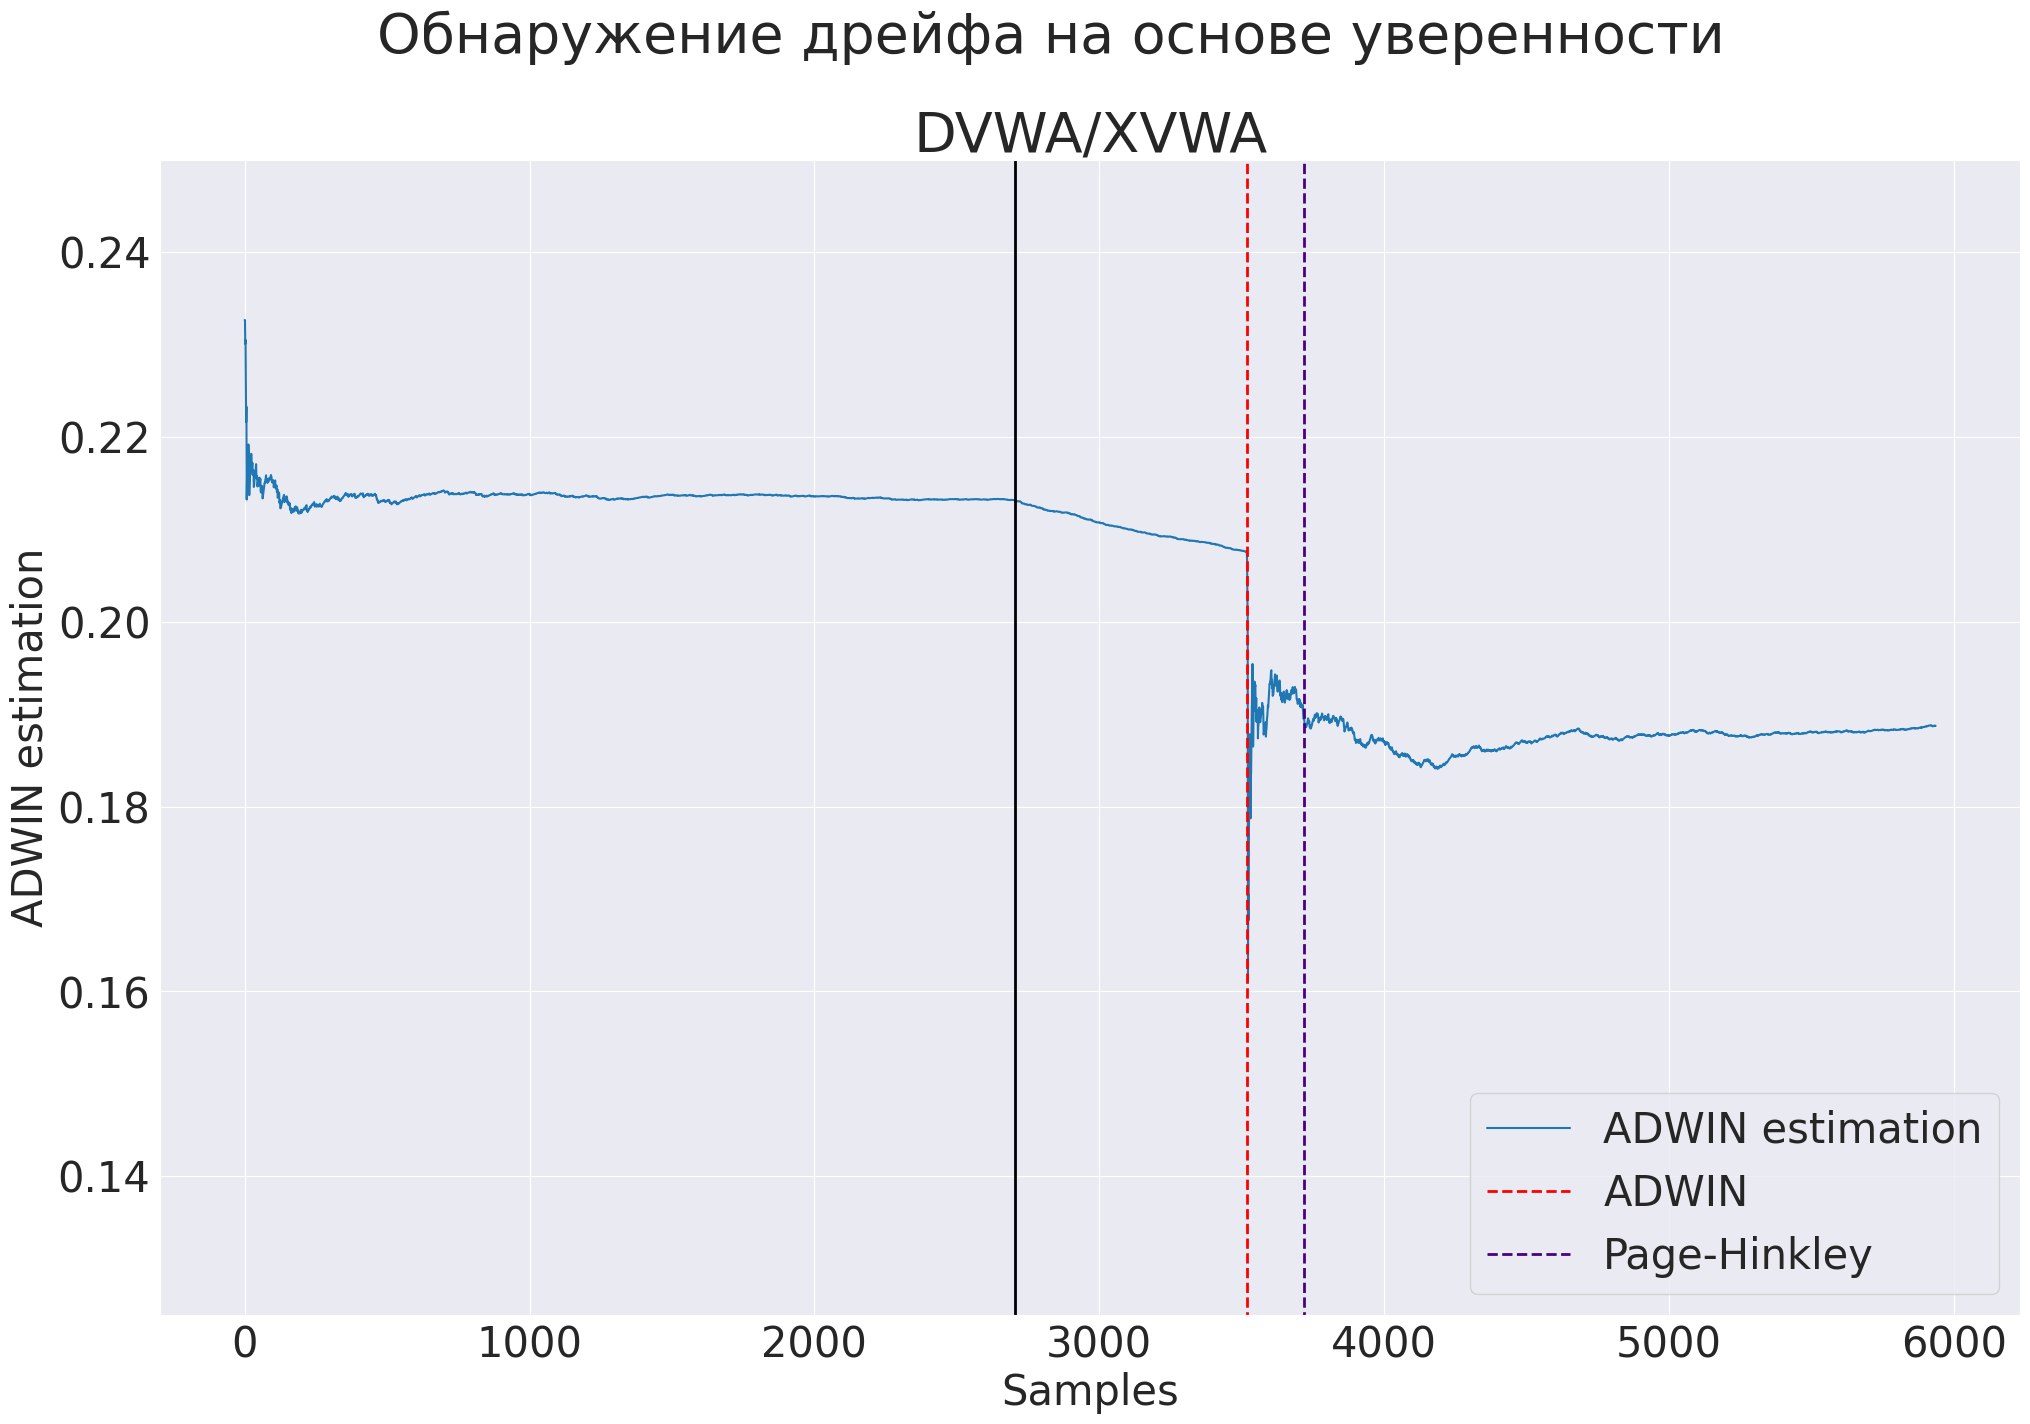

In [26]:
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,15)) 
sns.set_style("darkgrid")
plt.clf() 

plt.plot(t,est,label='ADWIN estimation')
# Draw the drift points/time
for i in dr_adwin:
    if i!=0:
        # plt.text(i-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(i, -1, 1, colors="red", linewidth=2, linestyles = "dashed", label='ADWIN')

for i in dr_KSWIN:
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(i, -1, 1, colors="green", linewidth=2, linestyles = "dashed", label='KSWIN')

for i in dr_pk:
    if i!=0:
        # plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
        plt.vlines(i, -1, 1, colors="indigo", linewidth=2, linestyles = "dashed", label='Page-Hinkley')

plt.vlines(point, -1, 1, colors="black", linewidth=2)
        
plt.legend(loc='lower right')
plt.ylim(0.125, 0.250)
plt.title('DVWA/XVWA', fontsize=40)
plt.suptitle("Обнаружение дрейфа на основе уверенности ", fontsize=40)
plt.xlabel('Samples')
plt.ylabel('ADWIN estimation')
plt.savefig("estimation_drift.png")